In [2]:
import jax
import jax.numpy as jnp
import flax
from flax import nnx
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from functools import partial
import math
from flax.nnx.nn import initializers
from collections import defaultdict
from typing import Callable
from utils import clipping_ste, intercore_connectivity

# plt.rcParams['text.usetex'] = True
# plt.rcParams['text.latex.preamble'] = r'\usepackage{type1cm}'

%load_ext autoreload
%autoreload 2

2025-07-01 19:34:39.013039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751423679.026579  425718 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751423679.030924  425718 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751423679.042526  425718 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751423679.042541  425718 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751423679.042543  425718 computation_placer.cc:177] computation placer alr

In [2]:
intercore_connectivity?

Signature:
intercore_connectivity(
    input_cores: int,
    output_cores: int,
    slots_per_core: int,
    avg_slot_connectivity: int,
    key: <function key at 0x7f42bdeafd80>,
    balanced: bool = True,
)
Docstring:
Returns a tensor C with shape (input_cores, total_input_slots, output_cores, total_output_slots).
C[ci, si, co, so] can be [-2, -1, 0, 1, 2].
1: connection to positive slots
-1: connection to negative slots
0: no connection
-2: rare but repeated connection to negative slot
2: rare but repeated connection to positive slot
File:      ~/github/TriDeNT/src/utils/intercore_connectivity.py
Type:      function

# Quantized activation functions with Straight through estimators

- Goal of this notebook is to put togeter the following quantized activation functions. Here is an intended list:
1. ReLU
2. Double rectified ReLU
3. Sigmoid



## ReLU

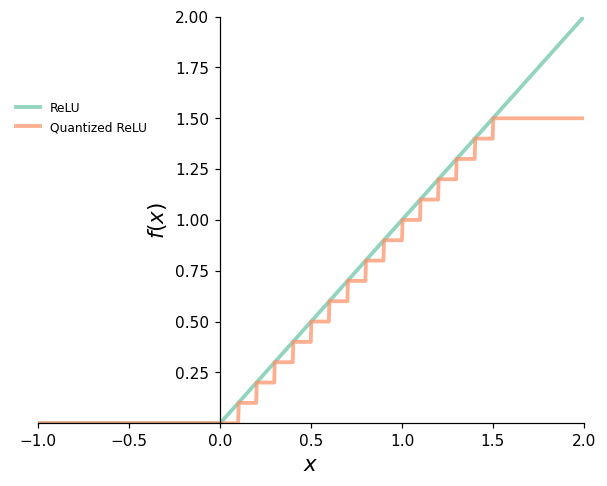

In [3]:
def quantized_relu(
    x: float, # input value, set up uses vmap
    bits: int = 4,
    max_value: float = 1.0,
):

    """
    Quantized relu function.
    Args:
        x: input value
        bits: number of bits for quantization
        max_value: maximum value for quantization
    
    Returns:
        Quantized value of x
    """

    # find the levels
    num_levels = 2**bits - 1

    # find the threshold
    thresholds = jnp.linspace(0, max_value, num_levels + 1)

    # find the corresponding mappings
    levels = nnx.relu(thresholds)

    # determine all indices where the thresholds are less than x
    less_than = levels < x

    # find the index of the largest threshold that is less than x
    idx = jnp.sum(less_than) - 1
    idx = jnp.clip(idx, 0, len(thresholds)-1)

    out = levels[idx]

    return out



# testing the quantized relu function
x_test = jnp.linspace(-1., 2., 1000)
x_relu = nnx.relu(x_test)
x_qrelu = jax.vmap(quantized_relu, in_axes=(0, None, None))(x_test, 4, 1.5)

# plotting 
fig, ax = plt.subplots(dpi = 110)
set10_pal = sns.color_palette("Set2", 10)
ax.plot(x_test, x_relu, label=r"ReLU", c=set10_pal[0], lw=2.5, alpha=.7)
ax.plot(x_test, x_qrelu, label=r"Quantized ReLU", c=set10_pal[1], lw=2.5, alpha=.7)
ax.set_xlabel(r"$x$", fontsize=14)
ax.set_ylabel(r"$f(x)$", fontsize=14)
ax.legend(frameon=False, loc=(-0.05, 0.7), fontsize = 8)
ax.set_yticks(jnp.linspace(0.25, 2.0, 8))

ax.set_xlim(-1.0, 2.0)
ax.set_ylim(0, 2.0)

ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

sns.despine()


In [3]:
# define backward pass for quantized relu
# treat it as if it were a relu
# @partial(jax.custom_vjp, nondiff_argnums=(1, 2))
def straight_through_quantized_relu(
    x: float, #input value,
    bits: int = 4,
    max_value: float = 1.0
):

    """
    Straight through estimator for quantized relu.
    """

    zero = x - jax.lax.stop_gradient(x)
    grad = zero + jax.lax.stop_gradient(quantized_relu(x, bits, max_value))

    return grad

# testing
print(f"q_relu(x) = {quantized_relu(0.5)}")
print(f"straight through forward = {straight_through_quantized_relu(0.5)}")

print(f"auto grad of q_relu = {jax.grad(quantized_relu)(0.5)}")
print(f"using STE = {jax.grad(straight_through_quantized_relu)(0.5)}")

q_relu(x) = 0.46666669845581055
straight through forward = 0.46666669845581055
auto grad of q_relu = 0.0
using STE = 1.0


In [4]:
# using custom_vjp
@partial(jax.custom_vjp, nondiff_argnums=(1, 2))
def quantized_relu_ste(
    x: float,
    bits: int = 8,
    max_value: float = 2.0,
    **kwargs
):

    return quantized_relu(x, bits, max_value)

def quantized_relu_fwd(
    x: float,
    bits: int = 8,
    max_value: float = 2.0,
    **kwargs
):

    primal_out = quantized_relu(x, bits, max_value)
    return primal_out, x

def quantized_relu_bwd(
    bits, max_value, residuals, gradients
):
    x = residuals
    grad = jnp.where(x > 0, 1.0, 0.0)

    return (grad*gradients, )

quantized_relu_ste.defvjp(quantized_relu_fwd, quantized_relu_bwd)

In [5]:
# testing
key = jax.random.key(1435)
x_test = jax.random.normal(key, (5, 10))

print(f"Test input = {x_test}")

# forward pass
x_test_shape = x_test.shape
y = jax.vmap(quantized_relu_ste, in_axes=(0, None, None))(x_test.flatten(), 8, 2.0)

print(f"Outs = {y}")


Test input = [[ 0.26492587  1.1237456   0.2940835   0.6650775   0.84790945  0.2143917
   0.06733563 -0.7074875  -0.1938227   0.3873634 ]
 [-0.50155795 -0.8824733   1.5763451  -0.15191355 -0.9742329  -0.08459407
  -1.9711989  -0.23225829  0.81321216  0.9419283 ]
 [ 0.8358773  -1.4805877  -2.2777958   0.27622217  0.8526375  -1.3873724
   1.6078974   0.3510882  -1.9227772   1.8008469 ]
 [ 1.1072831   1.2593466   0.12804882  0.76791936 -0.34087273  1.2219316
   1.0426373  -0.36649597 -2.1325328  -1.361489  ]
 [-1.5313423  -0.9063598   1.5172201  -0.87163955 -0.8793821  -0.18170193
  -0.65821224  0.7451525  -1.8369386   0.18719247]]
Outs = [0.25882354 1.1215687  0.2901961  0.65882355 0.8470589  0.21176472
 0.0627451  0.         0.         0.38431376 0.         0.
 1.5686276  0.         0.         0.         0.         0.
 0.8078432  0.94117653 0.8313726  0.         0.         0.27450982
 0.8470589  0.         1.6078433  0.34509805 0.         1.7960786
 1.1058824  1.254902   0.1254902  0.760

## Switching gears...
- Trying to put this activation in ScRRAMBLe module.
- Quantized Sigmoid would look very similar to the double sided ReLU as used above.

In [19]:
class ScRRAMBLeCapsuleNetwork(nnx.Module):
    """
    Experimental Capsule module with ScRRAMBLe Routing.
    Defines a set of capsules with receptive fields.
    Routing is done through ScRRAMBLe.

    A few analogies for using intercore_connectivity function that implements ScRRAMBLe.
    1. input_cores: number of capsules needed. Calculate as (input vector size) / (capsule size).
    2. output_cores: number of capsules to be routed to. Calculate as (output vector size) / (capsule size).
    3. slots_per_core: number of receptive fields per capsule. Take as a given integer. e.g. if capsule size is 256, 4 slots_per_core would mean that each capsule has 4 receptive fields of size 64.
    4. avg_slot_connectivity: lambda parameter. Same as before. But consider connectivity to a receptive field instead of a slot. slot == receptive field in this context.
    """

    def __init__(self,
                 input_vector_size: int, # size of flattened input vector
                 num_capsules: int, # treat this as number of cores that will be used but it doesn't have to be that
                 capsule_size: int, # size of each capsule e.g. 256 (number of columns/rows of a core)
                 receptive_field_size: int, # size of each receptive field e.g. 64 (number of columns/rows of a slot)
                 avg_receptive_field_connectivity: float, # between 0 and 1, average connectivity of a receptive field to the input vector
                 rngs: nnx.Rngs
                 ):
        
        self.input_vector_size = input_vector_size
        self.num_capsules = num_capsules
        self.capsule_size = capsule_size
        self.receptive_field_size = receptive_field_size
        self.rngs = rngs
        self.avg_receptive_field_connectivity = avg_receptive_field_connectivity

        # compute the number of receptive fields per capsule
        self.receptive_fields_per_capsule = math.ceil(self.capsule_size / self.receptive_field_size) # rounded up to the nearest integer

        # compute number of effective capsules coming from the input vector
        self.input_eff_capsules = math.ceil(self.input_vector_size / self.capsule_size) # rounded up to the nearest integer

        # initialize the ScRRAMBLe connectivity matrix
        Ci = intercore_connectivity(
            input_cores=self.input_eff_capsules,
            output_cores=self.num_capsules,
            slots_per_core=self.receptive_fields_per_capsule,
            avg_slot_connectivity=self.avg_receptive_field_connectivity,
            key=self.rngs.params()
        )

        self.Ci = nnx.Variable(Ci)

        # initialize the weights on the capsules
        initializer = initializers.glorot_normal()
        self.Wi = nnx.Param(initializer(self.rngs.params(), (self.num_capsules, self.receptive_fields_per_capsule, self.receptive_fields_per_capsule, self.receptive_field_size, self.receptive_field_size))) # e.g. (10, 4, 4, 64, 64)

    def __call__(self, x: jax.Array) -> jax.Array:
        """
        Forward pass through the capsule layer with ScRRAMBLe routing
        """

        # flatten the input
        x = x.flatten()

        # pad the input with zeros if the length is not a multiple of capsule size
        if x.shape[0]%self.capsule_size != 0:
            x_padded = jnp.pad(x, (0, self.input_eff_capsules*self.capsule_size - x.shape[0]), mode='constant', constant_values=0)
        else:
            x_padded = x
        
        # reshape input into (input_eff_capsules, receptive_fields_per_capsule, receptive_field_size)
        x_reshaped = x_padded.reshape(self.input_eff_capsules, self.receptive_fields_per_capsule, self.receptive_field_size)

        # ScRRAMBLe Routing to the cores
        x_routed = jnp.einsum('ijkl,ijm->klm', self.Ci, x_reshaped)

        y = jnp.einsum('ijklm,ikm->ijl', self.Wi, x_routed)

        return y






In [48]:
# testing the capsule network
rngs = nnx.Rngs(params=0, activation=1, default=46732)
test_input = jax.random.normal(rngs.params(), (10, 1000))
test_net = ScRRAMBLeCapsuleNetwork(
    input_vector_size=1000,
    num_capsules=10,
    capsule_size=256,
    receptive_field_size=64,
    avg_receptive_field_connectivity=15,
    rngs=rngs
)

nnx.display(test_net)

test_out = jax.vmap(test_net, in_axes=(0,))(test_input)

# testing the output shape
print(f"Test output shape = {test_out.shape}")
test_out = test_out.flatten()
test_out = jax.vmap(quantized_relu_ste, in_axes=(0, None, None))(test_out, 8, 1.0)
print(f"Some outputs = {test_out[:10]}")

Test output shape = (10, 10, 4, 64)
Some outputs = [0.60784316 0.24313727 0.         0.28235295 0.00784314 0.
 1.         0.         0.         0.0627451 ]


In [21]:
test_net.Wi.shape

(10, 4, 4, 64, 64)

## Visualizing the connectivity

In [42]:
def visualize_connectivity(
        learned_capsule_weights: jax.Array,
        routing_matrix: jax.Array,
        num_input_neurons: int,
        num_output_neurons: int,
        capsule_size: int,
        receptive_field_size: int,
        receptive_fields_per_capsule: int,
        num_capsules: int,
        num_eff_capsules: int,
        rngs: nnx.Rngs = nnx.Rngs(0),

) -> jax.Array:
    """
    Function returns a jax.Array Wc describing connectivity between neurons in one layer of the network.
    Args:
    1. learned_capsule_weights: jax.Array: Make sure that the shape is (self.Wi.shape[0], self.receptive_fields_per_capsule, self.receptive_fields_per_capsule, self.receptive_field_size, self.receptive_field_size) (5D tensor)
    2. Routing matrix: taken from the intercore_connectivity function. The shape should be (output cores, output slots, input cores, input slots)

    Returns:
    Wc: jax.Array of shape (num output neurons, num input neurons) where Wc[i, j] is the weight from input neuron j to output neuron i.
    """

    # initialize the giant connectivity matrix
    Wc = jnp.zeros((num_output_neurons, num_input_neurons))

    # set up for loops
    for co in range(num_capsules):
        for so in range(receptive_fields_per_capsule):
            for ci in range(num_eff_capsules):
                for si in range(receptive_fields_per_capsule):
                    print(f"co = {co}, so = {so}, ci = {ci}, si = {si}")
                    # get routing weight
                    r = routing_matrix[co, so, ci, si]

                    if r == 0:
                        continue
                    else:
                        W_dense = r*learned_capsule_weights[co, so , si, :, :]
                        print(W_dense.shape)
                        print(co*capsule_size + so*receptive_field_size)
                        print(co*capsule_size + (so+1)*receptive_field_size)
                        print(capsule_size*ci + receptive_field_size*si)
                        print(capsule_size*ci + (si+1)*receptive_field_size)
                        print(Wc[(co*capsule_size + so*receptive_field_size):(co*capsule_size + (so+1)*receptive_field_size), (capsule_size*ci + receptive_field_size*si):(capsule_size*ci + (si+1)*receptive_field_size)].shape)

                        Wc = Wc.at[(co*capsule_size + so*receptive_field_size):(co*capsule_size + (so+1)*receptive_field_size), (capsule_size*ci + receptive_field_size*si):(capsule_size*ci + (si+1)*receptive_field_size)].set(W_dense)

    
    return Wc






In [49]:
# testing the connectivity visualization function
Wc = visualize_connectivity(
    learned_capsule_weights=test_net.Wi.value,
    routing_matrix=test_net.Ci.value,
    num_input_neurons=test_net.input_eff_capsules * test_net.capsule_size,
    num_output_neurons=test_net.num_capsules * test_net.capsule_size,
    capsule_size=test_net.capsule_size,
    receptive_field_size=test_net.receptive_field_size,
    receptive_fields_per_capsule=test_net.receptive_fields_per_capsule,
    num_capsules=test_net.num_capsules,
    num_eff_capsules=test_net.input_eff_capsules,
    rngs=rngs

)

co = 0, so = 0, ci = 0, si = 0
co = 0, so = 0, ci = 0, si = 1
(64, 64)
0
64
64
128
(64, 64)
co = 0, so = 0, ci = 0, si = 2
(64, 64)
0
64
128
192
(64, 64)
co = 0, so = 0, ci = 0, si = 3
(64, 64)
0
64
192
256
(64, 64)
co = 0, so = 0, ci = 1, si = 0
(64, 64)
0
64
256
320
(64, 64)
co = 0, so = 0, ci = 1, si = 1
(64, 64)
0
64
320
384
(64, 64)
co = 0, so = 0, ci = 1, si = 2
co = 0, so = 0, ci = 1, si = 3
(64, 64)
0
64
448
512
(64, 64)
co = 0, so = 0, ci = 2, si = 0
co = 0, so = 0, ci = 2, si = 1
co = 0, so = 0, ci = 2, si = 2
co = 0, so = 0, ci = 2, si = 3
co = 0, so = 0, ci = 3, si = 0
(64, 64)
0
64
768
832
(64, 64)
co = 0, so = 0, ci = 3, si = 1
(64, 64)
0
64
832
896
(64, 64)
co = 0, so = 0, ci = 3, si = 2
(64, 64)
0
64
896
960
(64, 64)
co = 0, so = 0, ci = 3, si = 3
(64, 64)
0
64
960
1024
(64, 64)
co = 0, so = 1, ci = 0, si = 0
co = 0, so = 1, ci = 0, si = 1
(64, 64)
64
128
64
128
(64, 64)
co = 0, so = 1, ci = 0, si = 2
(64, 64)
64
128
128
192
(64, 64)
co = 0, so = 1, ci = 0, si = 3
co = 

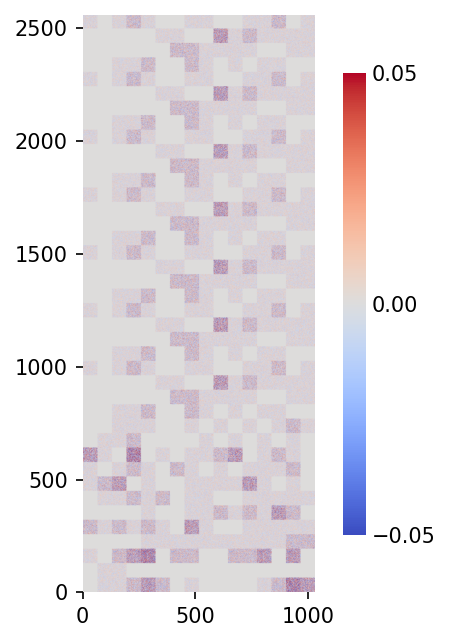

In [56]:
fig, ax = plt.subplots(dpi = 150, figsize = (5, 5))
im = ax.imshow(Wc, cmap='coolwarm', vmax=0.05, vmin=-0.05, origin='lower')
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.8, ticks=[-0.1, -0.05, 0, 0.05, 0.1])
cbar.outline.set_visible(False)
cbar.ax.tick_params(which='both', length=0, width=0, pad=3)
cbar.ax.minorticks_off()

sns.despine(fig, top=True, right=True, left=True, bottom=True)

## Let's try making a small network

In [5]:
for i in range(4):
    if i ==2:
        continue
    else:
        print(f"i={i}")
    for j in range(3):
        print(f"j = {j}")

i=0
j = 0
j = 1
j = 2
i=1
j = 0
j = 1
j = 2
i=3
j = 0
j = 1
j = 2


In [8]:
xx = jnp.arange(10)
xx[(1+1) : (2+3)]

Array([2, 3, 4], dtype=int32)